In [1]:
def plotspace(filename,datastart=26,types=True,minsec=False):
    # import basic packages and earth magnetic model
    import scipy.signal.windows as spsw
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    %matplotlib inline
    import re
    import chaosmagpy as cp
    from chaosmagpy.model_utils import synth_values
    from chaosmagpy.data_utils import mjd2000
    from chaosmagpy.plot_utils import plot_timeseries
    model = cp.load_CHAOS_matfile('CHAOS-6-x9.mat')
    possible_characters = ('-', ' ')
    path='/usr/people/out/Documents/Magnetic_field/'
    
##### calculate values from observation station #####
    # read-in file of station
    File=open(f'{path}{filename}','r') # open file
    counter=0
    HorX=[] # make some lists
    DeclY=[]
    VertZ=[]
    X=[]
    N=0
    for line in File:
        if counter==2:
            words=line.split()
            station=words[2]
        if counter==4:
            words=line.split()
            lat=float(words[2]) # latitude station
        if counter==5:
            words=line.split()
            lon=float(words[2]) # longitude station
        if counter>=datastart-1: #read when the data starts
            N+=1
            if counter==datastart-1:
                dates=re.split("[%s]" % ("".join(possible_characters)), line) # get start date
                
            words=line.split()
            HorX.append(float(words[3])) # get horizontal or X-component
            DeclY.append(float(words[4])) # get 'declination' or Y-component
            VertZ.append(float(words[5])) # get vertical component or Z-component
        counter+=1
    File.close()
    try:
        os.mkdir(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}')
    except Exception:
        pass
    
    if types: #if given in XYZ, types==true
        X=np.multiply(-1,HorX)
        Y=DeclY
        Z=np.multiply(-1,VertZ)
            
    else: #if given in HDZ, types==false
        for item in range(len(DeclY)):
            X.append(-np.sqrt(HorX[item]**2-DeclY[item]**2)) #minus is added to immediately transform to polar coordinates
        Y=DeclY
        Z=np.multiply(-1,VertZ)
##### calculate model value of magnetic field #####
    # set up
    if minsec:
        secormin='sec'
    else:
        secormin='min'

    if int(dates[2])==31:
        if int(dates[1])==12:
            time = np.linspace(mjd2000(int(dates[0]),int(dates[1]),int(dates[2])), 
                               mjd2000(int(dates[0])+1,1,1), num=N)
        else:
            time = np.linspace(mjd2000(int(dates[0]),int(dates[1]),int(dates[2])), 
                               mjd2000(int(dates[0]),int(dates[1])+1,1), num=N)
    else:
        time = np.linspace(mjd2000(int(dates[0]),int(dates[1]),int(dates[2])),
                           mjd2000(int(dates[0]),int(dates[1]),int(dates[2])+1), num=N)
    radius = 6371.2
    theta = 90.-lat #90 degrees minus latitude

    # calculate values for temporal and static field
    coeffs = model.synth_coeffs_tdep(time, nmax=16, deriv=0)
    B_radius, B_theta, B_phi = synth_values(coeffs, radius, theta, phi)
    coeffstat = model.synth_coeffs_static()
    Bstat_radius, Bstat_theta, Bstat_phi = synth_values(coeffstat, radius, theta, phi)
        
##### subtract the two data sets! #####
    SpaceX=X-B_theta-Bstat_theta
    SpaceY=Y-B_phi-Bstat_phi
    SpaceZ=Z-B_radius-Bstat_radius
        
##### plot data #####
    figx=plt.figure(figsize=(20,10))
    ax1=figx.add_subplot(311)
    ax11=figx.add_subplot(312)
    ax12=figx.add_subplot(313)
    ax1.set_title('$B_\\theta$ at '+ station + ' on ' + dates[0] + '-' + dates[1] + '-' + dates[2])
    ax12.set_xlabel('time (days after 1 jan 2000)')
    ax11.set_ylabel('$B_\\theta$ (nt)')
    ax11.plot(time,X,label='observed',color='blue')
    ax12.plot(time,B_theta+Bstat_theta,label='model',color='green')
    ax1.plot(time,SpaceX,label='residue',color='red')
    ax1.legend()
    ax11.legend()
    ax12.legend()

    figy=plt.figure(figsize=(20,10))
    ax2=figy.add_subplot(311)
    ax21=figy.add_subplot(312)
    ax22=figy.add_subplot(313)
    ax2.set_title('$B_\\phi$ at '+ station + ' on ' + dates[0] + '-' + dates[1] + '-' + dates[2])
    ax22.set_xlabel('time (days after 1 jan 2000)')
    ax21.set_ylabel('$B_\\phi$ (nt)')
    ax21.plot(time,Y,label='total',color='blue')
    ax22.plot(time,B_phi+Bstat_phi,label='model',color='green')
    ax2.plot(time,SpaceY,label='residue',color='red')
    ax2.legend()
    ax21.legend()
    ax22.legend()

    figz=plt.figure(figsize=(20,10))
    ax3=figz.add_subplot(311)
    ax31=figz.add_subplot(312)
    ax32=figz.add_subplot(313)
    ax3.set_title('$B_r$ at '+ station + ' on ' + dates[0] + '-' + dates[1] + '-' + dates[2])
    ax32.set_xlabel('time (days after 1 jan 2000)')
    ax31.set_ylabel('$B_r$ (nt)')
    ax31.plot(time,Z,label='total',color='blue')
    ax32.plot(time,B_radius+Bstat_radius,label='model',color='green')
    ax3.plot(time,SpaceZ,label='residue',color='red')
    ax3.legend()
    ax31.legend()
    ax32.legend()
    plt.show()
    
    figall=plt.figure(figsize=(20,10))
    ax4=figall.add_subplot(311)
    ax41=figall.add_subplot(312)
    ax42=figall.add_subplot(313)
    ax4.set_title('Radial component')
    ax41.set_title('Longitudinal component')
    ax41.set_ylabel('nanoteslas')
    ax42.set_title('Latitudional component')
    ax4.plot(time,SpaceZ,color='red')
    ax41.plot(time,SpaceY,color='red')
    ax42.plot(time,SpaceX,color='red')
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/SWresult.png')
    
##### calculate frequency spectrum #####
    # try to get time derivative and frequency at which this happens, only horizontal components matter
    dXdt=np.zeros(len(SpaceX)) # define length array
    dYdt=np.zeros(len(SpaceY))

    for item in range(len(SpaceX)-1): # obtain derivative
        dXdt[item]=SpaceX[item+1]-SpaceX[item]
        dYdt[item]=SpaceY[item+1]-SpaceY[item]

    figx=plt.figure()
    ax1=figx.add_subplot()
    ax1.set_title('d$B_X$/dt at ' + station)
    ax1.set_xlabel('time (days after 1 jan 2000)')
    ax1.set_ylabel(f'd$B_X$/dt (nt/{secormin})')
    ax1.plot(time,dXdt,label='residue',color='red')
    ax1.legend()
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/db\dtX.png')

    figy=plt.figure()
    ax2=figy.add_subplot()
    ax2.set_title('d$B_Y$/dt at ' + station)
    ax2.set_xlabel('time (days after 1 jan 2000)')
    ax2.set_ylabel(f'd$B_Y$/dt (nt/{secormin})')
    ax2.plot(time,dYdt,label='residue',color='red')
    ax2.legend()
#     plt.show()
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/db\dtY.png')
    
    # get frequencyplot
    dXdt2=dXdt*spsw.hann(N)
    dYdt2=dYdt*spsw.hann(N)
    FdXshift=np.fft.fft(dXdt2) # get frequency component
    FdX=np.abs(np.fft.fftshift(FdXshift)) # shift it to the middle of the plot
    FdYshift=np.fft.fft(dYdt2) # get frequency component
    FdY=np.abs(np.fft.fftshift(FdYshift)) # shift it to the middle of the plot
    
    if minsec:
        Nu_c=1./(2.*1/60) # Nyquist frequency (1/min)
        df=60./N #frequencystepping
    else:
        Nu_c=1./(2*1.)
        df=1./N
    freq=np.arange(-Nu_c,Nu_c,df)
    # freq=np.fft.fftfreq(len(dXdt),60)
    figfx=plt.figure()
    ax1=figfx.add_subplot()
    ax1.set_title('frequencyplot at ' + station)
    ax1.set_xlabel('frequency X (1/min)')
    ax1.set_xlim(-0.5,0.5)
    ax1.set_ylabel('Amplitude')
    ax1.plot(freq,FdX,label='residue',color='red')
    ax1.legend()
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/frequencyX.png')
    figfy=plt.figure()
    ax2=figfy.add_subplot()
    ax2.set_title('frequencyplot at ' + station)
    ax2.set_xlabel('frequency Y (1/min)')
    ax2.set_xlim(-0.5,0.5)
    ax2.set_ylabel('Amplitude')
    ax2.plot(freq,FdY,label='residue',color='red')
    ax2.legend()
#     plt.show()
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/frequencyY.png')
    
    ### horizontal component ###
    Hor_comp=np.sqrt(SpaceX**2+SpaceY**2)
    dHdt=np.zeros(len(Hor_comp))
    for item in range(len(Hor_comp)-1): # obtain derivative
        dHdt[item]=Hor_comp[item+1]-Hor_comp[item]
    dHdt2=dHdt*spsw.hann(N)
    FdHshift=np.fft.fft(dHdt2)
    FdH=np.abs(np.fft.fftshift(FdHshift))
    figH=plt.figure()
    ax1=figH.add_subplot(211)
    ax1.set_title('horizontal component at ' + station)
    ax1.set_xlabel('time')
    ax1.set_ylabel('nT')
    ax1.plot(time,Hor_comp,color='red')
    ax2=figH.add_subplot(212)
    ax2.set_xlabel('time')
    ax2.set_ylabel('nT/min')
    ax2.plot(time,dHdt,color='red')
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/Horizontal_data.png')
    
    figHf=plt.figure()
    ax3=figHf.add_subplot(111)
    ax3.set_xlabel('frequency (1/min)')
    ax3.set_ylabel('horizontal Amplitude')
    ax3.plot(freq,FdH,color='red')
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/Horizontal_frequency.png')
    
# ##### save files #####
    newfile=pd.DataFrame(columns=['B_theta (nt)','B_phi (nt)','B_r (nt)','B_H','dBx/dt','dBy/dt','dBH/dt'])
    for i in range(N):
        newfile.loc[i]=SpaceX[i], SpaceY[i], SpaceZ[i], Hor_comp[i], dXdt[i], dYdt[i], dHdt[i]
    newfile.to_csv(path_or_buf=f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/allresults.csv', sep=';', index=False, header=True)

In [7]:
def newplotspace(filename1,filename2,datastart=26,types=True,minsec=False):
    # import basic packages and earth magnetic model
    import scipy.signal.windows as spsw
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    %matplotlib inline
    import re
    import chaosmagpy as cp
    from chaosmagpy.model_utils import synth_values
    from chaosmagpy.data_utils import mjd2000
    from chaosmagpy.plot_utils import plot_timeseries
    model = cp.load_CHAOS_matfile('CHAOS-6-x9.mat')
    possible_characters = ('-', ' ')
    path='/usr/people/out/Documents/Magnetic_field/'
    
##### calculate values from observation station #####
    # read-in file of station
    File=open(f'{path}{filename2}','r') # open file
    counter=0
    HorX=[] # make some lists
    DeclY=[]
    VertZ=[]
    X2=[]
    N=0
    for line in File:
        if counter==2:
            words=line.split()
            station=words[2]
        if counter==4:
            words=line.split()
            lat=float(words[2]) # latitude station
        if counter==5:
            words=line.split()
            lon=float(words[2]) # longitude station
        if counter>=datastart-1: #read when the data starts
            N+=1
            if counter==datastart-1:
                dates=re.split("[%s]" % ("".join(possible_characters)), line) # get start date
                
            words=line.split()
            HorX.append(float(words[3])) # get horizontal or X-component
            DeclY.append(float(words[4])) # get 'declination' or Y-component
            VertZ.append(float(words[5])) # get vertical component or Z-component
        counter+=1
    File.close()
    
    if types: #if given in XYZ, types==true
        X2=HorX
        Y2=DeclY
        Z2=VertZ
            
    else: #if given in HDZ, types==false
        for item in range(len(DeclY)):
            X2.append(np.sqrt(HorX[item]**2-DeclY[item]**2)) #minus is added to immediately transform to polar coordinates
        Y2=DeclY
        Z2=VertZ
        
    File=open(f'{path}{filename1}','r') # open file
    counter=0
    HorX=[] # make some lists
    DeclY=[]
    VertZ=[]
    X1=[]
    N=0
    for line in File:
        if counter==2:
            words=line.split()
            station=words[2]
        if counter==4:
            words=line.split()
            lat=float(words[2]) # latitude station
        if counter==5:
            words=line.split()
            lon=float(words[2]) # longitude station
        if counter>=datastart-1: #read when the data starts
            N+=1
            if counter==datastart-1:
                dates=re.split("[%s]" % ("".join(possible_characters)), line) # get start date
                
            words=line.split()
            HorX.append(float(words[3])) # get horizontal or X-component
            DeclY.append(float(words[4])) # get 'declination' or Y-component
            VertZ.append(float(words[5])) # get vertical component or Z-component
        counter+=1
    File.close()
    try:
        os.mkdir(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}')
    except Exception:
        pass
    
    if types: #if given in XYZ, types==true
        X1=HorX
        Y1=DeclY
        Z1=VertZ
            
    else: #if given in HDZ, types==false
        for item in range(len(DeclY)):
            X1.append(np.sqrt(HorX[item]**2-DeclY[item]**2)) #minus is added to immediately transform to polar coordinates
        Y1=DeclY
        Z1=VertZ
##### calculate model value of magnetic field #####
    # set up
    if minsec:
        secormin='sec'
    else:
        secormin='min'

    if int(dates[2])==31:
        if int(dates[1])==12:
            time = np.linspace(mjd2000(int(dates[0]),int(dates[1]),int(dates[2])), 
                               mjd2000(int(dates[0])+1,1,1), num=N)
        else:
            time = np.linspace(mjd2000(int(dates[0]),int(dates[1]),int(dates[2])), 
                               mjd2000(int(dates[0]),int(dates[1])+1,1), num=N)
    else:
        time = np.linspace(mjd2000(int(dates[0]),int(dates[1]),int(dates[2])),
                           mjd2000(int(dates[0]),int(dates[1]),int(dates[2])+1), num=N)
    
##### subtract the two data sets! #####
    SpaceX=np.subtract(X1,X2)
    SpaceY=np.subtract(Y1,Y2)
    SpaceZ=np.subtract(Z1,Z2)
        
##### plot data #####
    figx=plt.figure(figsize=(20,10))
    ax1=figx.add_subplot(311)
    ax11=figx.add_subplot(312)
    ax12=figx.add_subplot(313)
    ax1.set_title('$B_\\theta$ at '+ station + ' on ' + dates[0] + '-' + dates[1] + '-' + dates[2])
    ax12.set_xlabel('time (days after 1 jan 2000)')
    ax11.set_ylabel('$B_\\theta$ (nt)')
    ax11.plot(time,X1,label='observed',color='blue')
    ax12.plot(time,X2,label='model',color='green')
    ax1.plot(time,SpaceX,label='residue',color='red')
    ax1.legend()
    ax11.legend()
    ax12.legend()

    figy=plt.figure(figsize=(20,10))
    ax2=figy.add_subplot(311)
    ax21=figy.add_subplot(312)
    ax22=figy.add_subplot(313)
    ax2.set_title('$B_\\phi$ at '+ station + ' on ' + dates[0] + '-' + dates[1] + '-' + dates[2])
    ax22.set_xlabel('time (days after 1 jan 2000)')
    ax21.set_ylabel('$B_\\phi$ (nt)')
    ax21.plot(time,Y1,label='total',color='blue')
    ax22.plot(time,Y2,label='model',color='green')
    ax2.plot(time,SpaceY,label='residue',color='red')
    ax2.legend()
    ax21.legend()
    ax22.legend()

    figz=plt.figure(figsize=(20,10))
    ax3=figz.add_subplot(311)
    ax31=figz.add_subplot(312)
    ax32=figz.add_subplot(313)
    ax3.set_title('$B_r$ at '+ station + ' on ' + dates[0] + '-' + dates[1] + '-' + dates[2])
    ax32.set_xlabel('time (days after 1 jan 2000)')
    ax31.set_ylabel('$B_r$ (nt)')
    ax31.plot(time,Z1,label='total',color='blue')
    ax32.plot(time,Z2,label='model',color='green')
    ax3.plot(time,SpaceZ,label='residue',color='red')
    ax3.legend()
    ax31.legend()
    ax32.legend()
    plt.show()
    
    figall=plt.figure(figsize=(20,10))
    ax4=figall.add_subplot(311)
    ax41=figall.add_subplot(312)
    ax42=figall.add_subplot(313)
    ax4.set_title('Radial component')
    ax41.set_title('Longitudinal component')
    ax41.set_ylabel('nanoteslas')
    ax42.set_title('Latitudional component')
    ax4.plot(time,SpaceZ,color='red')
    ax41.plot(time,SpaceY,color='red')
    ax42.plot(time,SpaceX,color='red')
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/SWresult.png')
    
##### calculate frequency spectrum #####
    # try to get time derivative and frequency at which this happens, only horizontal components matter
    dXdt=np.zeros(len(SpaceX)) # define length array
    dYdt=np.zeros(len(SpaceY))

    for item in range(len(SpaceX)-1): # obtain derivative
        dXdt[item]=SpaceX[item+1]-SpaceX[item]
        dYdt[item]=SpaceY[item+1]-SpaceY[item]

    figx=plt.figure()
    ax1=figx.add_subplot()
    ax1.set_title('d$B_X$/dt at ' + station)
    ax1.set_xlabel('time (days after 1 jan 2000)')
    ax1.set_ylabel(f'd$B_X$/dt (nt/{secormin})')
    ax1.plot(time,dXdt,label='residue',color='red')
    ax1.legend()
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/db\dtX.png')

    figy=plt.figure()
    ax2=figy.add_subplot()
    ax2.set_title('d$B_Y$/dt at ' + station)
    ax2.set_xlabel('time (days after 1 jan 2000)')
    ax2.set_ylabel(f'd$B_Y$/dt (nt/{secormin})')
    ax2.plot(time,dYdt,label='residue',color='red')
    ax2.legend()
#     plt.show()
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/db\dtY.png')
    
    # get frequencyplot
    dXdt2=dXdt*spsw.hann(N)
    dYdt2=dYdt*spsw.hann(N)
    FdXshift=np.fft.fft(dXdt2) # get frequency component
    FdX=np.abs(np.fft.fftshift(FdXshift)) # shift it to the middle of the plot
    FdYshift=np.fft.fft(dYdt2) # get frequency component
    FdY=np.abs(np.fft.fftshift(FdYshift)) # shift it to the middle of the plot
    
    if minsec:
        Nu_c=1./(2.*1/60) # Nyquist frequency (1/min)
        df=60./N #frequencystepping
    else:
        Nu_c=1./(2*1.)
        df=1./N
    freq=np.arange(-Nu_c,Nu_c,df)
    # freq=np.fft.fftfreq(len(dXdt),60)
    figfx=plt.figure()
    ax1=figfx.add_subplot()
    ax1.set_title('frequencyplot at ' + station)
    ax1.set_xlabel('frequency X (1/min)')
    ax1.set_xlim(-0.5,0.5)
    ax1.set_ylabel('Amplitude')
    ax1.plot(freq,FdX,label='residue',color='red')
    ax1.legend()
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/frequencyX.png')
    figfy=plt.figure()
    ax2=figfy.add_subplot()
    ax2.set_title('frequencyplot at ' + station)
    ax2.set_xlabel('frequency Y (1/min)')
    ax2.set_xlim(-0.5,0.5)
    ax2.set_ylabel('Amplitude')
    ax2.plot(freq,FdY,label='residue',color='red')
    ax2.legend()
#     plt.show()
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/frequencyY.png')
    
    ### horizontal component ###
    Hor_comp=np.sqrt(SpaceX**2+SpaceY**2)
    dHdt=np.zeros(len(Hor_comp))
    for item in range(len(Hor_comp)-1): # obtain derivative
        dHdt[item]=Hor_comp[item+1]-Hor_comp[item]
    dHdt2=dHdt*spsw.hann(N)
    FdHshift=np.fft.fft(dHdt2)
    FdH=np.abs(np.fft.fftshift(FdHshift))
    figH=plt.figure()
    ax1=figH.add_subplot(211)
    ax1.set_title('horizontal component at ' + station)
    ax1.set_xlabel('time')
    ax1.set_ylabel('nT')
    ax1.plot(time,Hor_comp,color='red')
    ax2=figH.add_subplot(212)
    ax2.set_xlabel('time')
    ax2.set_ylabel('nT/min')
    ax2.plot(time,dHdt,color='red')
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/Horizontal_data.png')
    
    figHf=plt.figure()
    ax3=figHf.add_subplot(111)
    ax3.set_xlabel('frequency (1/min)')
    ax3.set_ylabel('horizontal Amplitude')
    ax3.plot(freq,FdH,color='red')
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/Horizontal_frequency.png')
    
# ##### save files #####
    newfile=pd.DataFrame(columns=['B_theta (nt)','B_phi (nt)','B_r (nt)','B_H','dBx/dt','dBy/dt','dBH/dt'])
    for i in range(N):
        newfile.loc[i]=SpaceX[i], SpaceY[i], SpaceZ[i], Hor_comp[i], dXdt[i], dYdt[i], dHdt[i]
    newfile.to_csv(path_or_buf=f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/allresults.csv', sep=';', index=False, header=True)

In [9]:
import os
path='/usr/people/out/Documents/Magnetic_field/'
path2='magnetic_data/31-10-2003'
string=os.listdir(f'{path}{path2}')
string=sorted(string)
for counter,item in enumerate(string):
    print(f'string[{counter}] = {string[counter]}')

path3='magnetic_data/23-10-2003'
string2=os.listdir(f'{path}{path3}')
string2=sorted(string2)
for counter,item in enumerate(string2):
    print(f'string[{counter}] = {string2[counter]}')

string[0] = bfe20031031dmin.min
string[1] = clf20031031dmin.min
string[2] = dou20031031dmin.min
string[3] = esk20031031dmin.min
string[4] = fur20031031dmin.min
string[5] = had20031031dmin.min
string[6] = ler20031031dmin.min
string[7] = ngk20031031dmin.min
string[8] = ups20031031dmin.min
string[9] = wng20031031dmin.min
string[0] = bfe20031023dmin.min
string[1] = clf20031023dmin.min
string[2] = dou20031023dmin.min
string[3] = esk20031023dmin.min
string[4] = fur20031023dmin.min
string[5] = had20031023dmin.min
string[6] = ler20031023dmin.min
string[7] = ngk20031023dmin.min
string[8] = ups20031023dmin.min
string[9] = wng20031023dmin.min


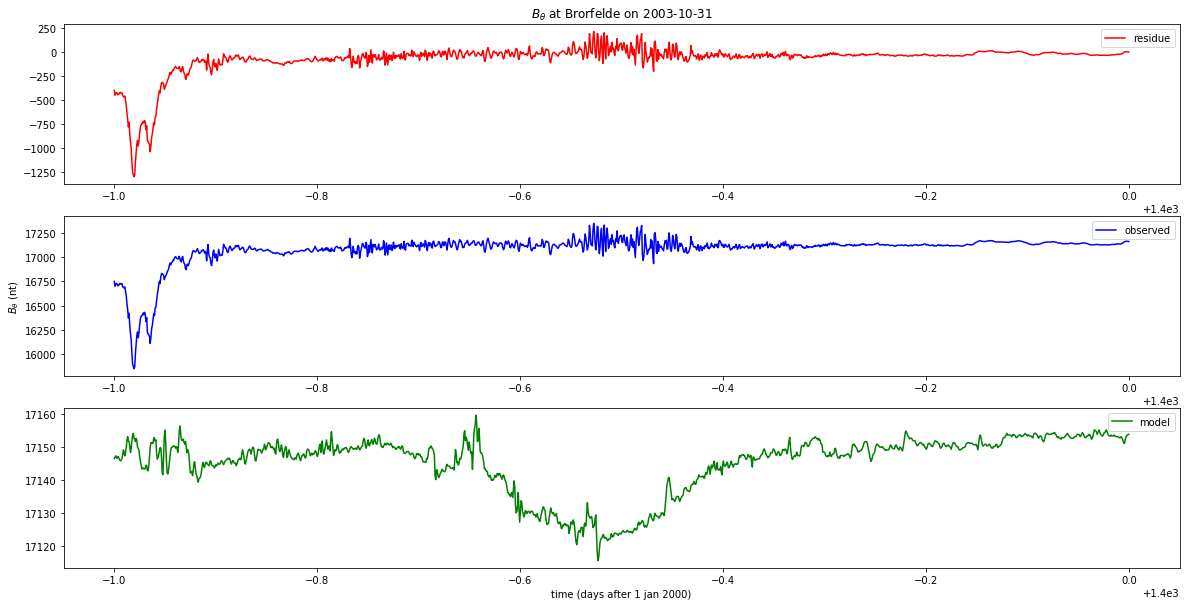

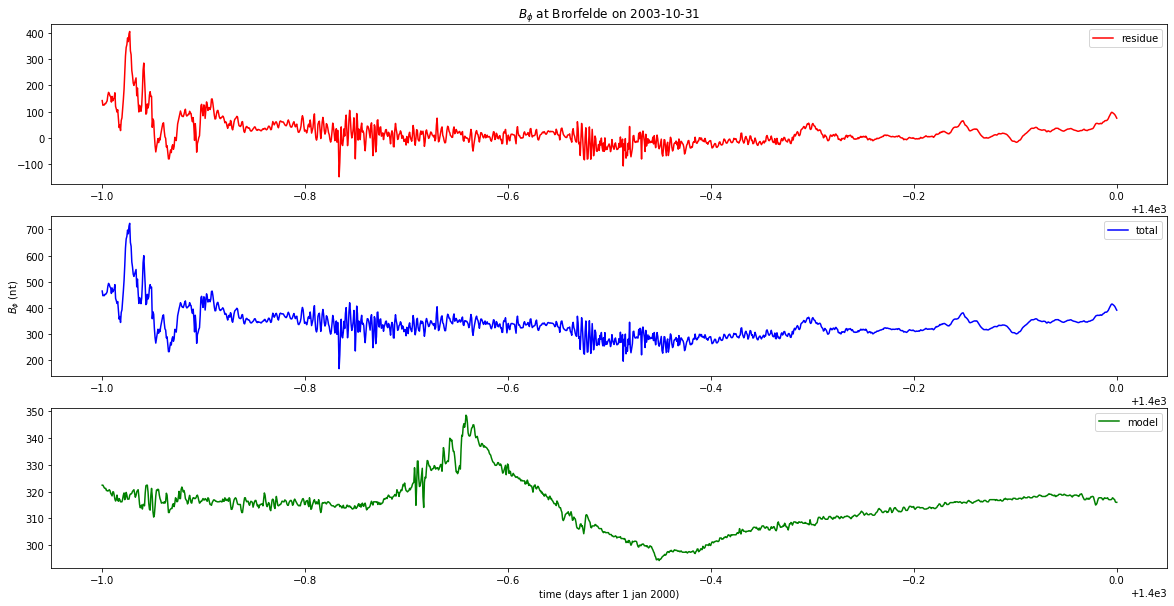

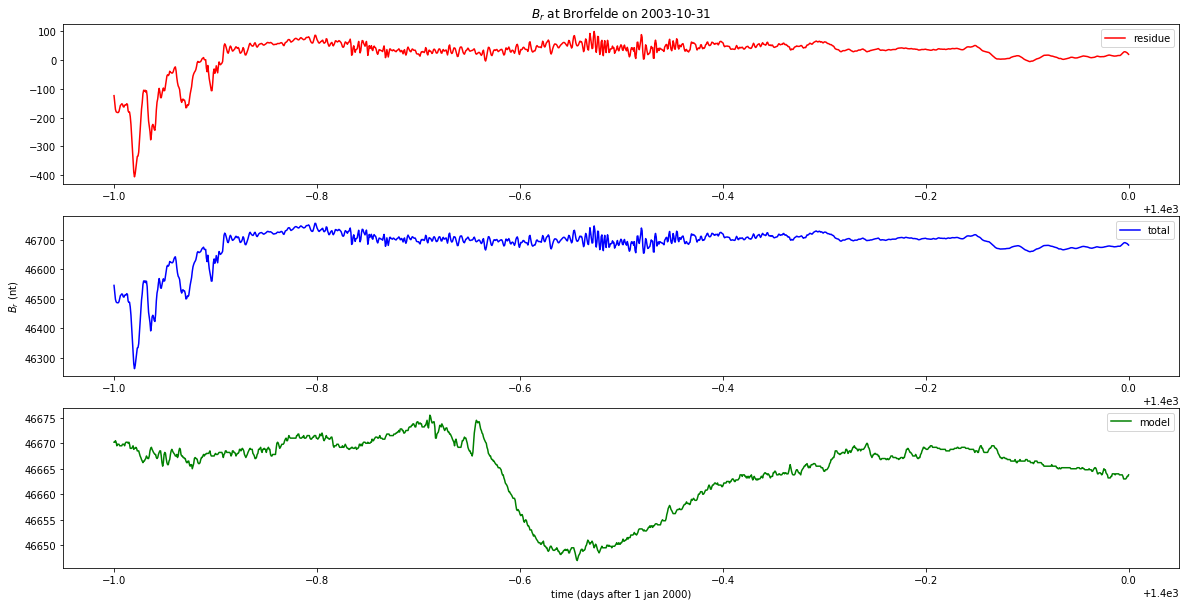

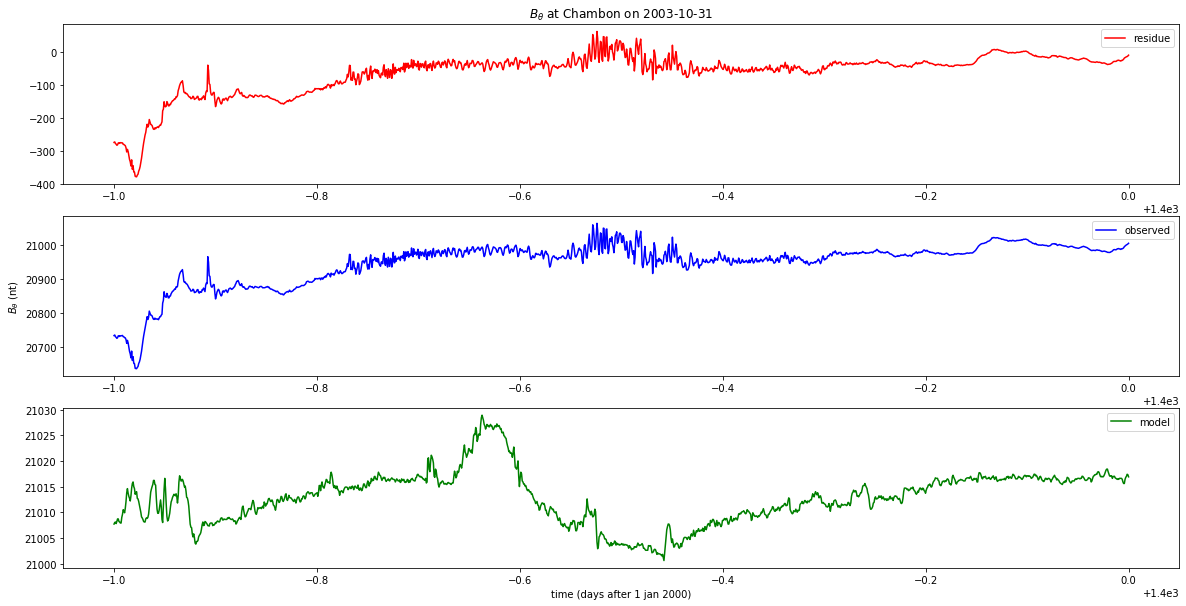

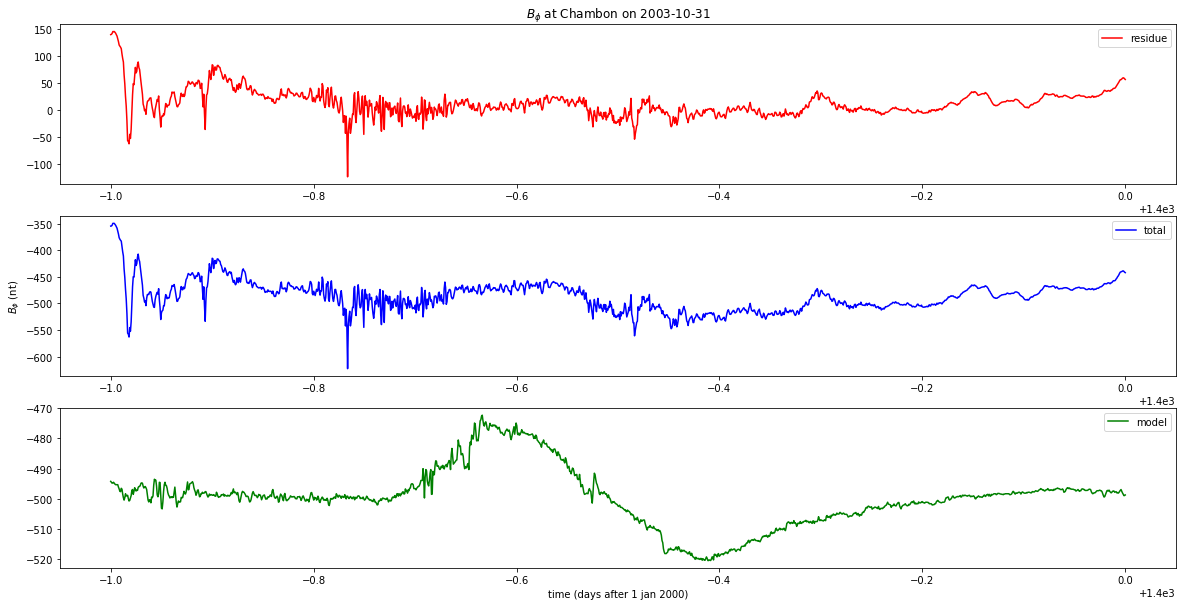

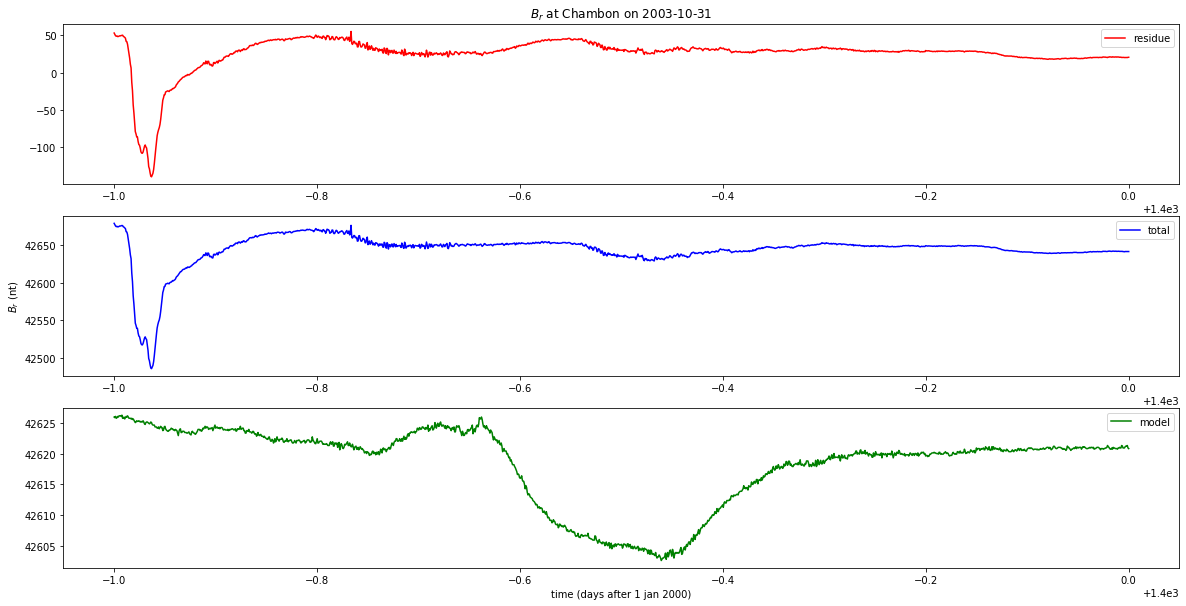

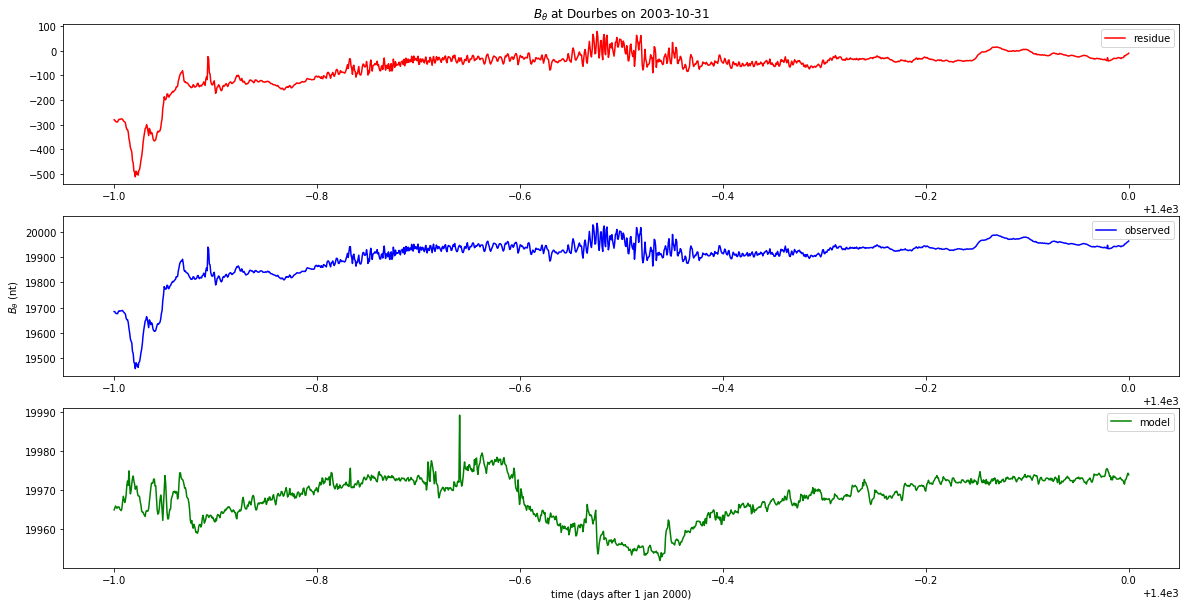

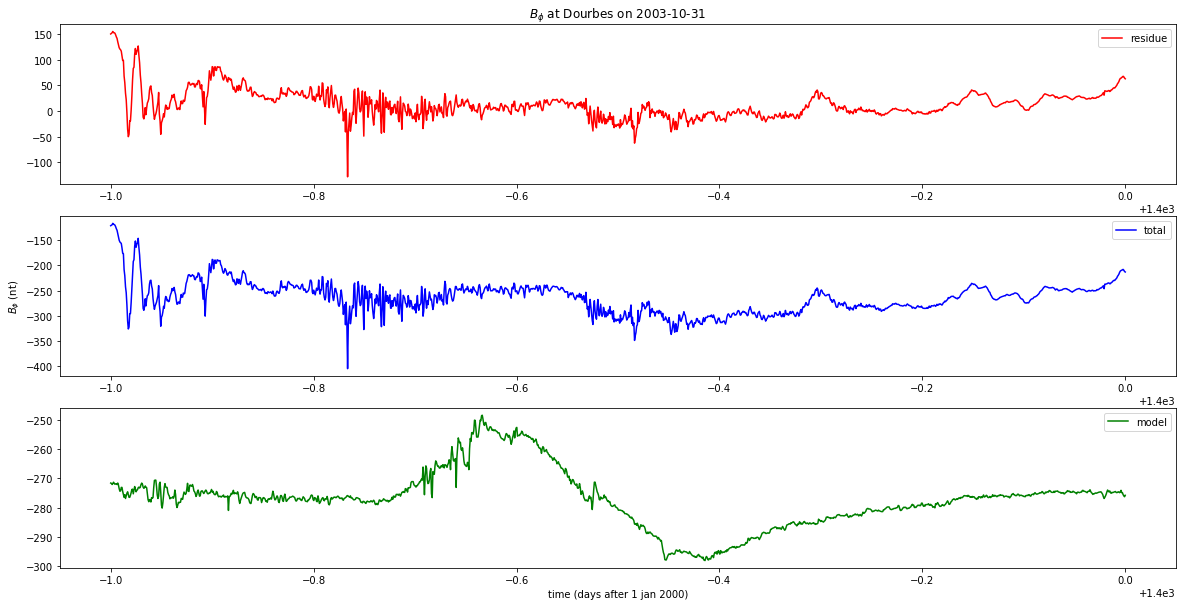

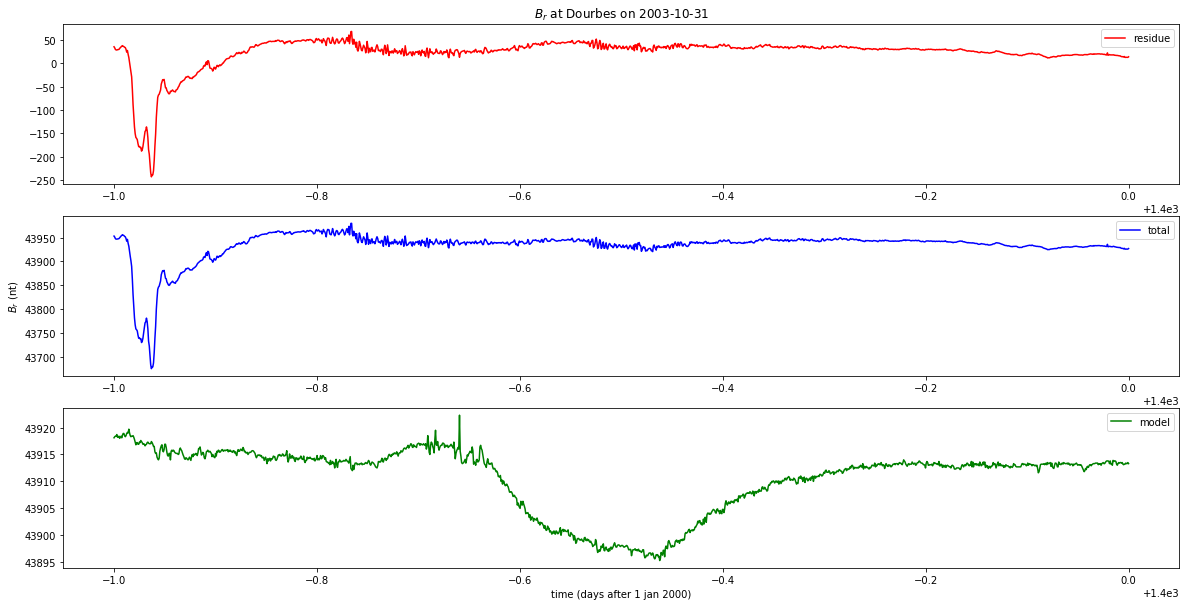

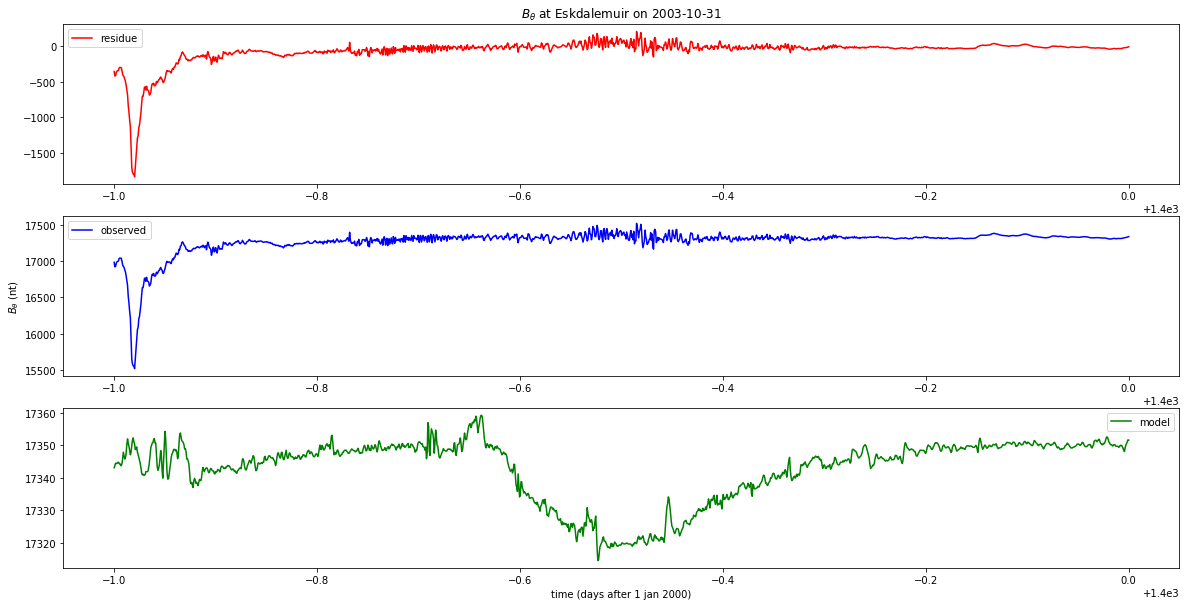

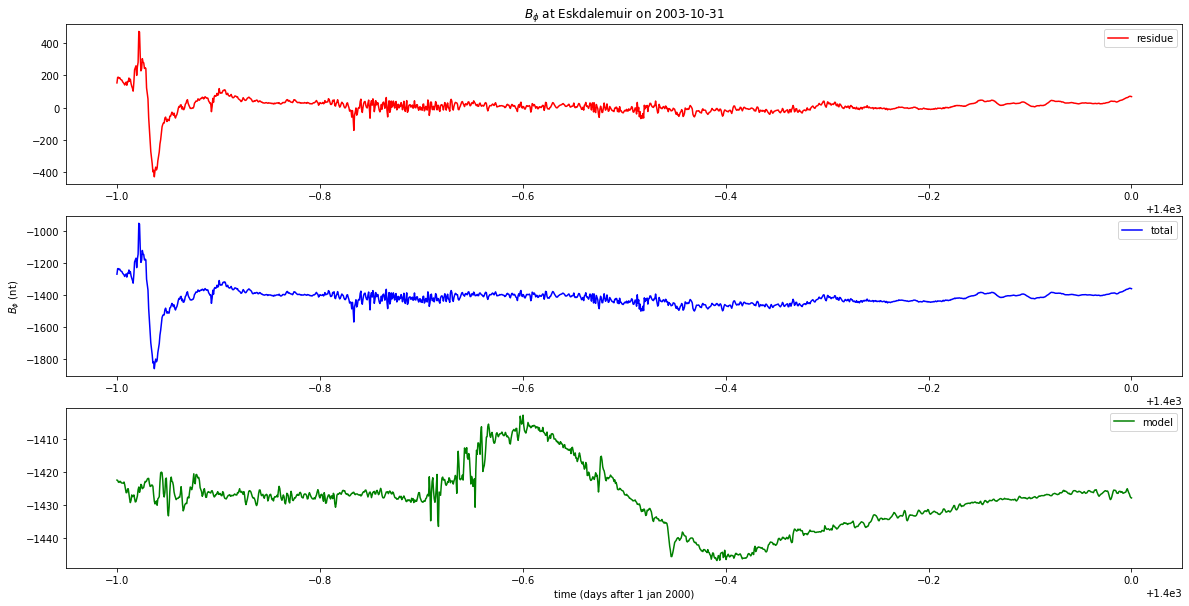

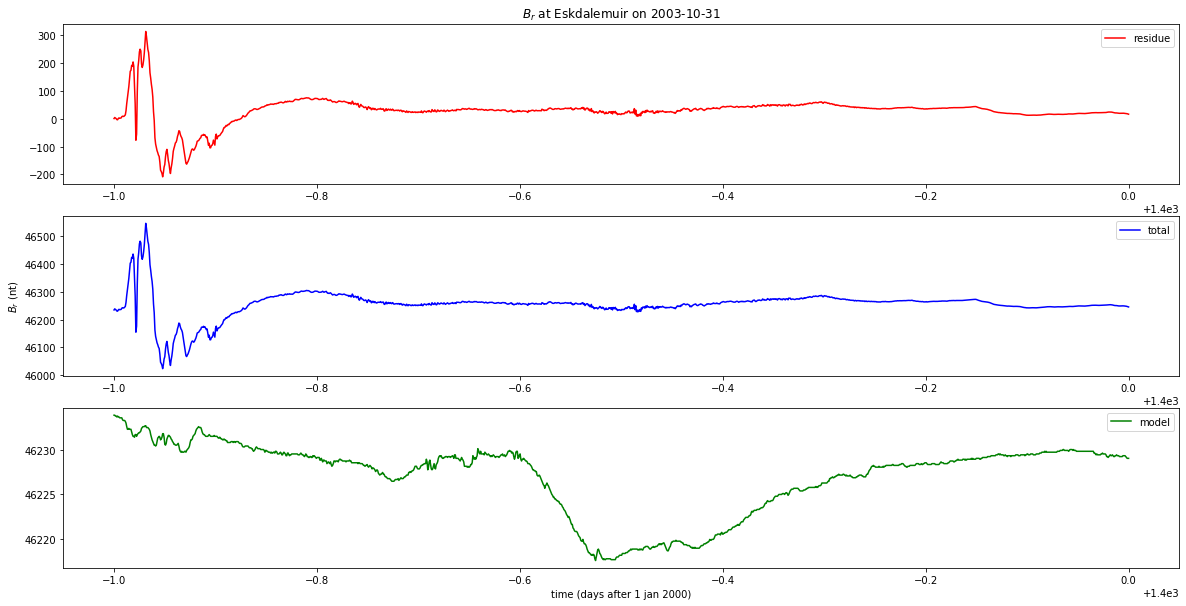

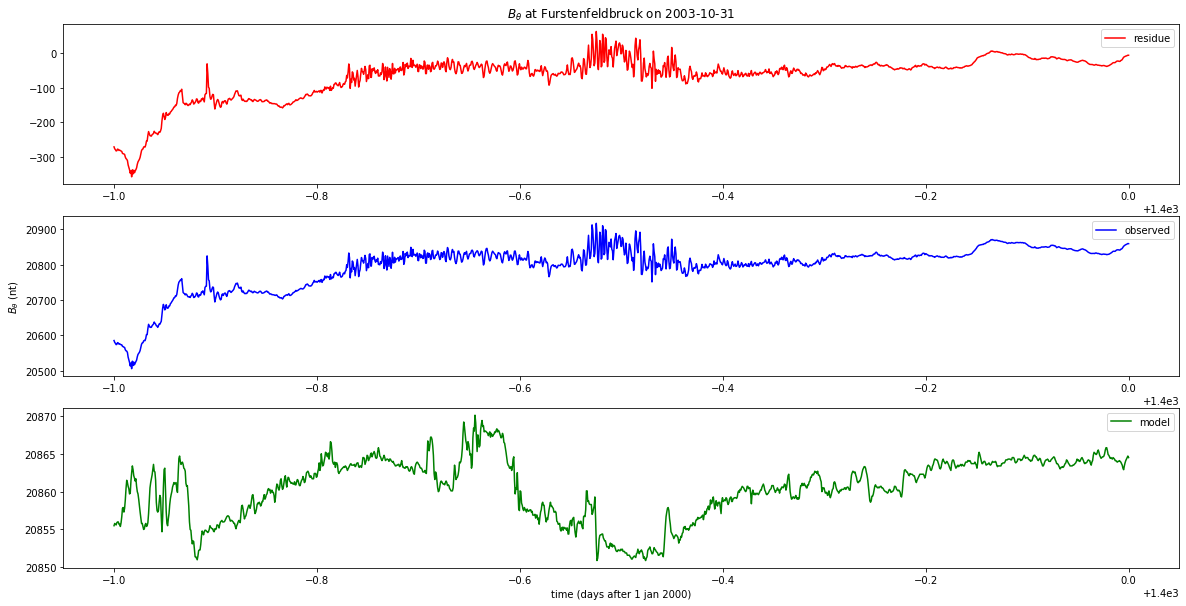

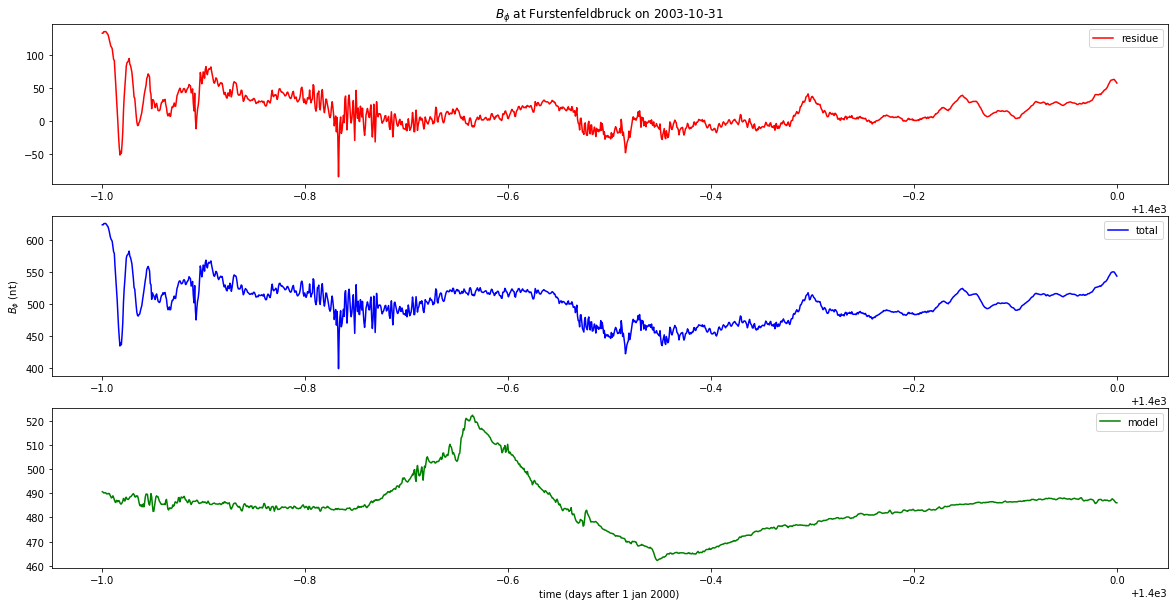

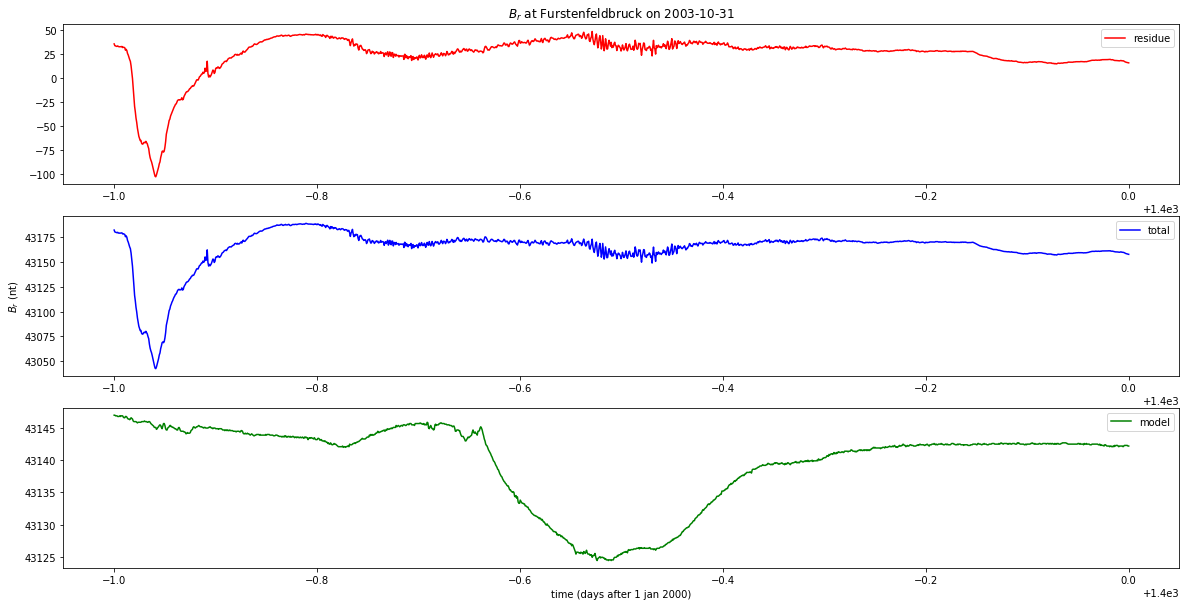

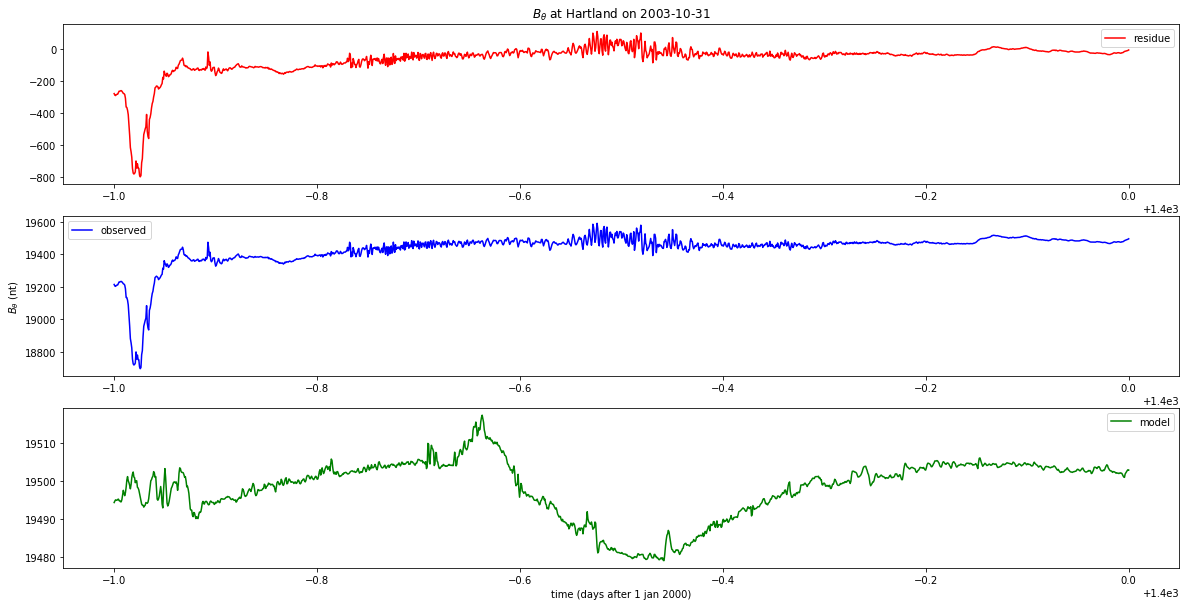

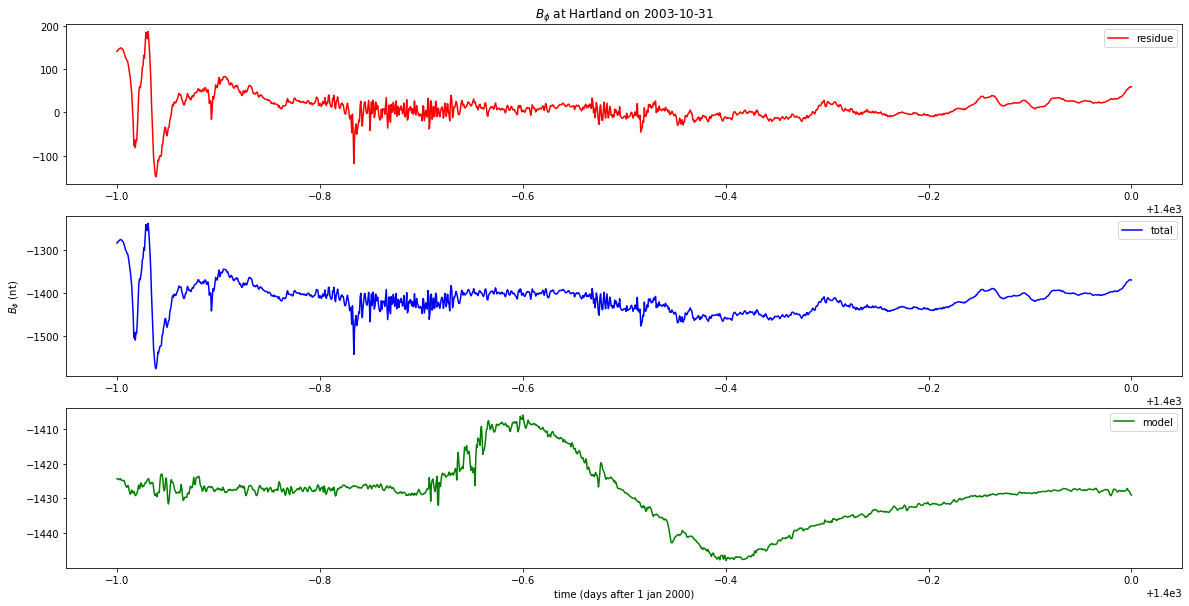

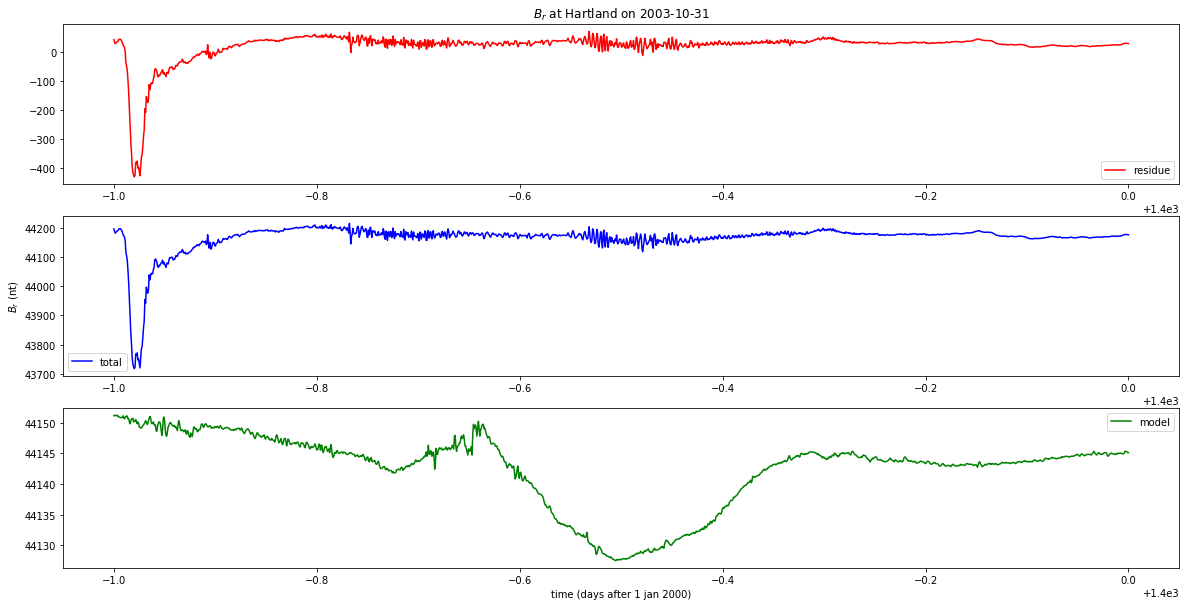

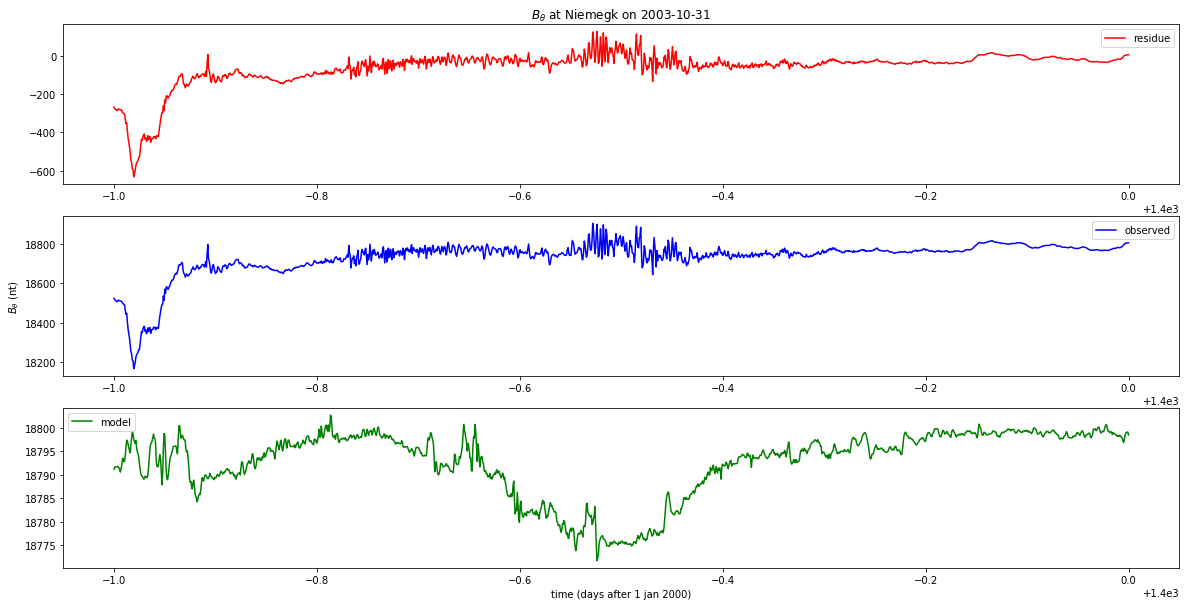

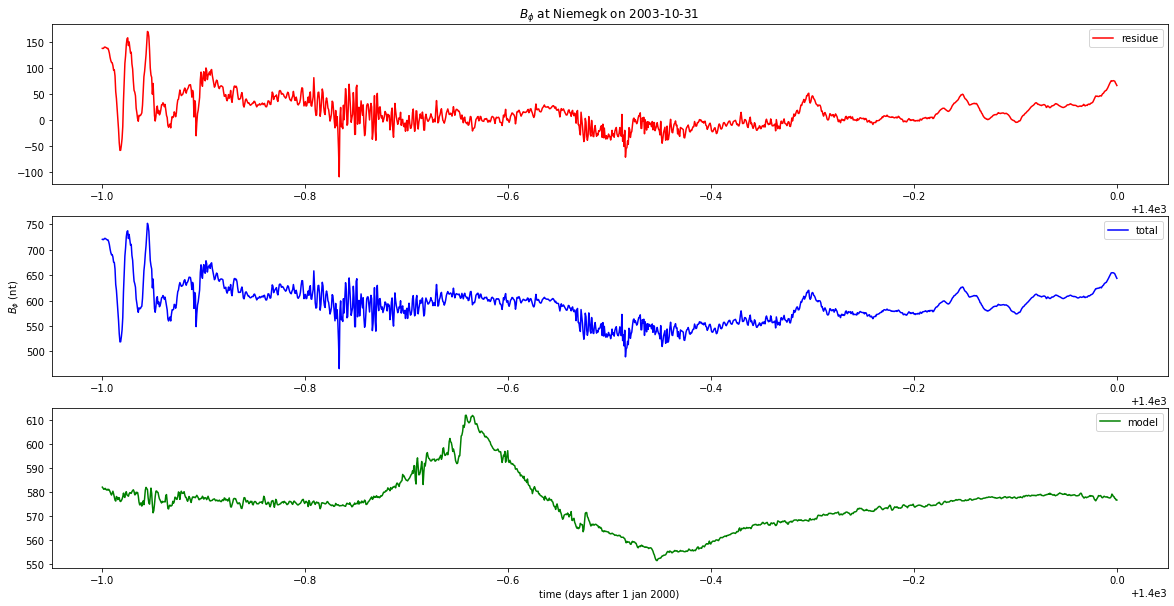

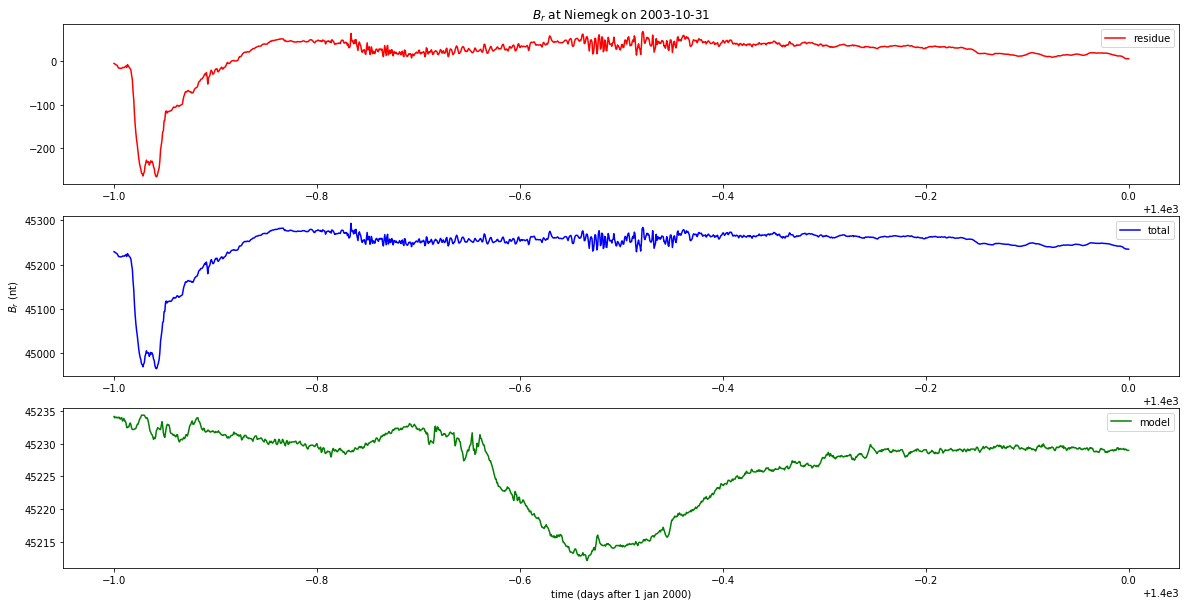

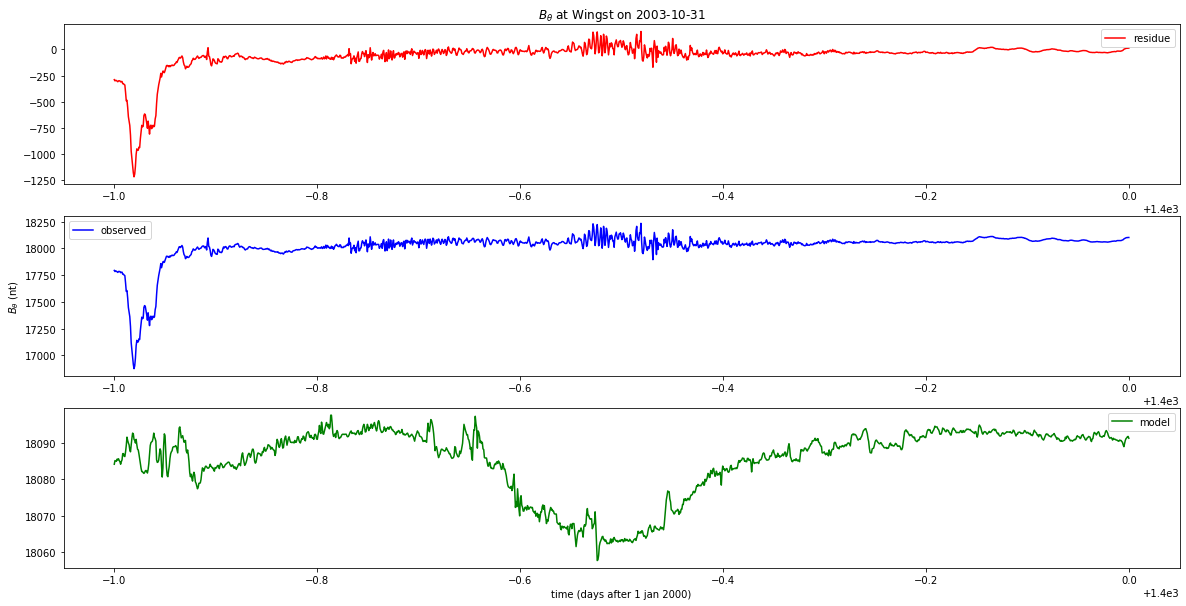

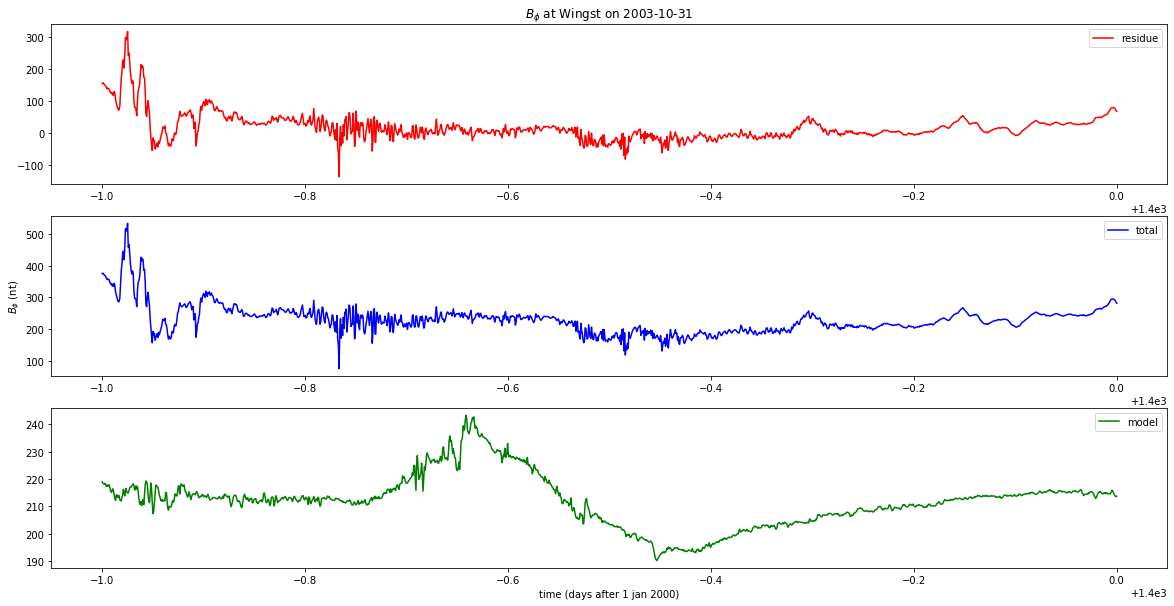

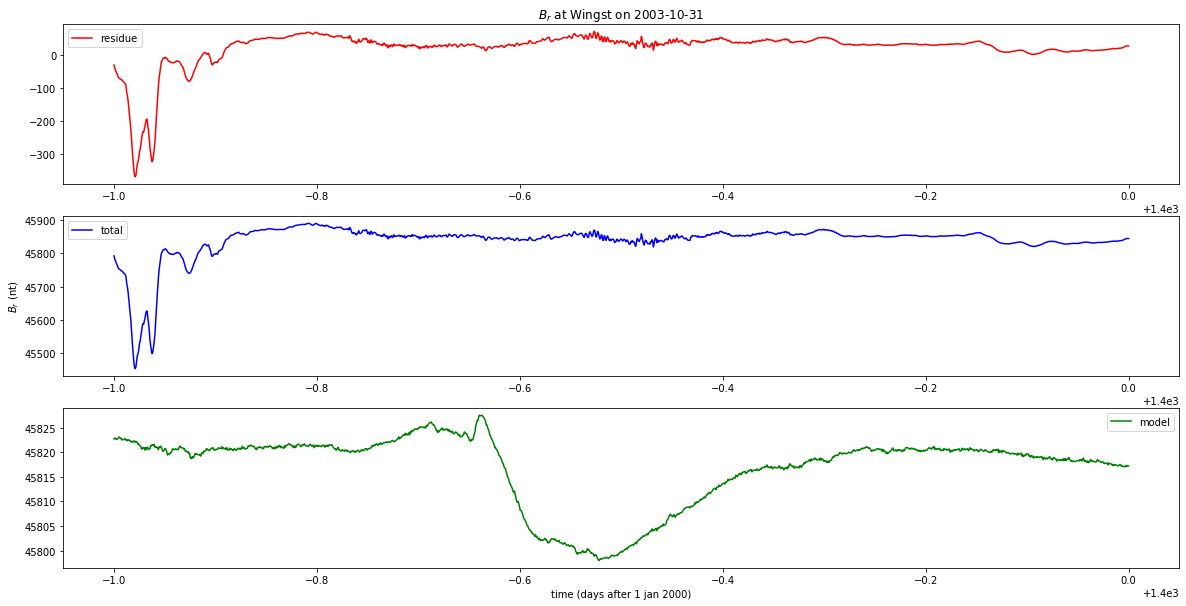

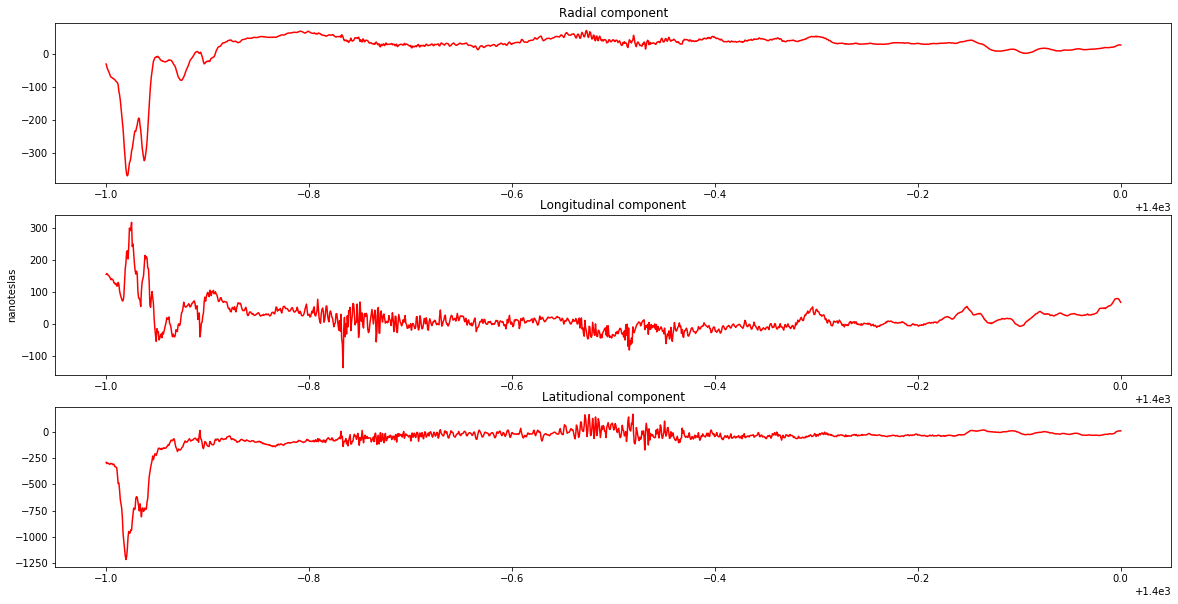

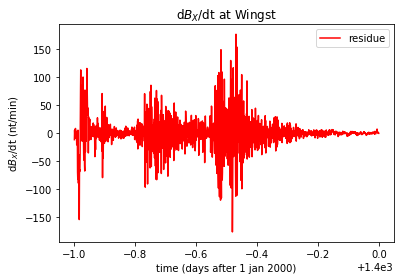

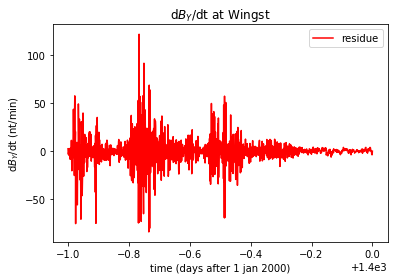

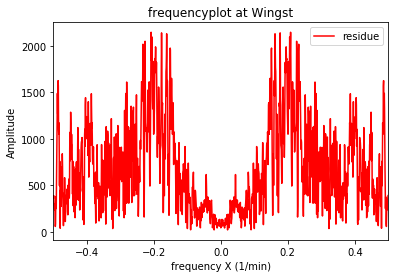

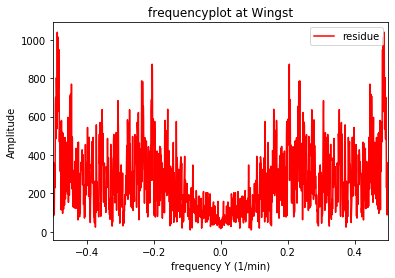

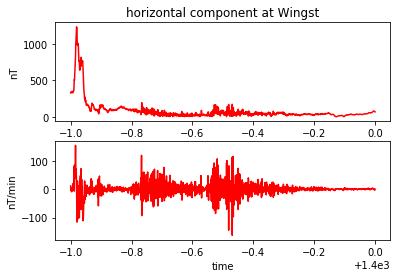

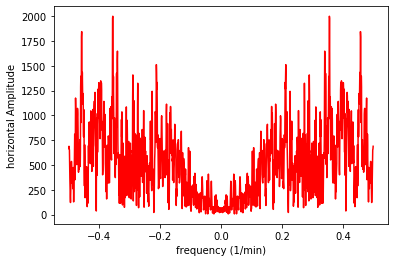

In [18]:
for item in range(len(string)):
    newplotspace(f'{path2}/{string[item]}',f'{path3}/{string2[item]}', datastart=27,types=True,minsec=False)

In [1]:
########################################### old version #########################################################
def mag_interpolate(loc,val,latlon,delta):
    import numpy as np
    from pySECS import SECS
    if loc.shape[-1] != 3:
        raise ValueError("Observation locations must have 3 columns (lat, lon, r)")
    if val.shape[-1] != 3:
        raise ValueError("Observed values must have 3 columns (Bx(theta), By(phi), Bz(r))")
    if latlon.shape[-1] != 4:
        raise ValueError("Observed values must have 1 row and 4 columns (latmin, latmax, lonmin, lonmax)")
    RE=6371e3
    
    latlon[1]+=delta
    latlon[3]+=delta
    
    lats = np.arange(latlon[0], latlon[1], delta)
    lons = np.arange(latlon[2], latlon[3], delta)

    nlat = len(lats)
    nlon = len(lons)

    xx, yy = np.meshgrid(lons, lats) #make nice mesh

    sec_loc=np.zeros((nlat*nlon,3))
    for i in range(nlat*nlon): #add poles to sec_loc
        sec_loc[i,:]=[yy.item(i),xx.item(i),RE+110e3] #system is 110 km above ground with multiple poles

    system_df = SECS(sec_df_loc=sec_loc) #initiate new divergence free system using poles (only df free, see paper)
    
    system_df.fit(loc,val) #fit currents to values
    
################## The prediction/interpolation begins ################
    predlats = np.arange(49, 54.04, 0.05) #Netherlands+Belgium&Germany
    predlons = np.arange(3.3, 9.64, 0.05)
    predlatseng = np.arange(51.4, 52.04, 0.05) #seacable england
    predlonseng = np.arange(0.7, 3.29, 0.05)
    predlatsnor = np.arange(54.05, 58.34, 0.05) #seacable norway
    predlonsnor = np.arange(6.1, 6.94, 0.05)

    nrpoint=len(predlats)*len(predlons)+len(predlatseng)*len(predlonseng)+len(predlatsnor)*len(predlonsnor)

    predxx1, predyy1 = np.meshgrid(predlons, predlats) #make nice mesh
    predxx2, predyy2 = np.meshgrid(predlonseng, predlatseng)
    predxx3, predyy3 = np.meshgrid(predlonsnor, predlatsnor)
    predxx=np.concatenate((predxx1.flatten(),predxx2.flatten(),predxx3.flatten()))
    predyy=np.concatenate((predyy1.flatten(),predyy2.flatten(),predyy3.flatten()))
#     nrpoint=1
#     predyy=np.array([50.1])
#     predxx=np.array([4.599])
    pred_loc=np.zeros((nrpoint,3))
    for i in range(nrpoint): #add locations
        pred_loc[i,:]=[predyy.item(i),predxx.item(i),RE] #system is at ground
    
    prediction=system_df.predict(pred_loc, False)
    result=np.zeros((nrpoint,4))
    for i in range(nrpoint):
        result[i,:]=[predyy.item(i),predxx.item(i),prediction[i,0],prediction[i,1]]
    return result
####################################################################################################################

In [12]:
######################################### Old version ##############################################################
import os
import pandas as pd
import numpy as np

RE=6371000
path='/usr/people/out/Documents/Magnetic_field/'
day='new_29-10-2003'
day2='29-10-2003'

string=os.listdir(f'{path}magnetic_data/{day2}')
string=sorted(string) #sort alphabetically, otherwise problems later
print(string)
location=np.zeros((len(string),3))
location[:,2]=RE
for counter1,item in enumerate(string):
    File=open(f'{path}magnetic_data/{day2}/{item}','r')
    for counter2,line in enumerate(File):
        if counter2==4:
            word=line.split()
            location[counter1,0]=word[2] #latitude
        if counter2==5:
            word=line.split()
            location[counter1,1]=word[2] #longitude
            break
    File.close()

string=os.listdir(f'{path}station_results/{day}') 
string=sorted(string) #sort alphabetically, otherwise problems now
print(string)
values=np.zeros((len(string),3))
try:
    os.mkdir(f'{path}station_results/interpolation_{day}')
except:
    pass
for counter3 in range(419,420): #minutes per day
    for counter1,item in enumerate(string):
        File=open(f'{path}station_results/{day}/{item}/allresults.csv')
        for counter2,line in enumerate(File):
            if counter2==counter3+1:
                word=line.split(';')
                values[counter1,:]=[word[0],word[1],word[2]]
                break
        File.close()
        
    result=mag_interpolate(location,values,np.array([43,63,-13,20]),0.5)
    print(result)
    newfile1=pd.DataFrame(columns=['lat','lon','Bx'])
    newfile2=pd.DataFrame(columns=['lat','lon','By'])
    for i in range(len(result)):
        newfile1.loc[i]=result[i,1], result[i,0], result[i,2]
        newfile2.loc[i]=result[i,1], result[i,0], result[i,3]
    if counter3<10:
        newfile1.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_000{counter3}.csv', sep=' ', index=False, header=False)
        newfile2.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_000{counter3}.csv.Y', sep=' ', index=False, header=False)
    elif counter3<100 and counter3>9:
        newfile1.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_00{counter3}.csv', sep=' ', index=False, header=False)
        newfile2.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_00{counter3}.csv.Y', sep=' ', index=False, header=False)
    elif counter3<1000 and counter3>99:
        newfile1.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_0{counter3}.csv', sep=' ', index=False, header=False)
        newfile2.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_0{counter3}.csv.Y', sep=' ', index=False, header=False)
    else:
        newfile1.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_{counter3}.csv', sep=' ', index=False, header=False)
        newfile2.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_{counter3}.csv.Y', sep=' ', index=False, header=False)
#####################################################################################################################

['bfe20031029dmin.min', 'clf20031029dmin.min', 'dou20031029dmin.min', 'esk20031029dmin.min', 'fur20031029dmin.min', 'had20031029dmin.min', 'ngk20031029dmin.min', 'wng20031029dmin.min']
['new_Brorfelde_2003-10-29', 'new_Chambon_2003-10-29', 'new_Dourbes_2003-10-29', 'new_Eskdalemuir_2003-10-29', 'new_Furstenfeldbruck_2003-10-29', 'new_Hartland_2003-10-29', 'new_Niemegk_2003-10-29', 'new_Wingst_2003-10-29']
[[   49.             3.3         -757.88284719   136.99144373]
 [   49.             3.35        -759.3769749    139.14943872]
 [   49.             3.4         -760.9060889    141.12837189]
 ...
 [   58.3            6.8        -1174.39933048   617.84744643]
 [   58.3            6.85       -1174.203179     622.47119823]
 [   58.3            6.9        -1174.03146164   627.05343792]]


FileNotFoundError: [Errno 2] No such file or directory: '/usr/people/out/Documents/Magnetic_field/station_results/new_29-10-2003/interpolation/minute_0419.csv'

In [4]:
## import os
import re
import logging
import os
# import time
import pandas as pd
import numpy as np
import threading
from multiprocessing import Process
from multiprocessing import Lock
# import concurrent.futures
from pySECS import SECS   
# lock=threading.Lock()
localvar=threading.local()
lock=Lock()

def magnetic_time(q,stepmin,stepmax,path,day,location,string,newpath):
    def mag_interpolate(loc,val,latlon,delta):
        if loc.shape[-1] != 3:
            raise ValueError("Observation locations must have 3 columns (lat, lon, r)")
        if val.shape[-1] != 3:
            raise ValueError("Observed values must have 3 columns (Bx(theta), By(phi), Bz(r))")
        if latlon.shape[-1] != 4:
            raise ValueError("Observed values must have 1 row and 4 columns (latmin, latmax, lonmin, lonmax)")
        RE=6371e3

        latlon[1]+=delta
        latlon[3]+=delta

        lats = np.arange(latlon[0], latlon[1], delta)
        lons = np.arange(latlon[2], latlon[3], delta)

        nlat = len(lats)
        nlon = len(lons)

        xx, yy = np.meshgrid(lons, lats) #make nice mesh

        sec_loc=np.zeros((nlat*nlon,3))
        for i in range(nlat*nlon): #add poles to sec_loc
            sec_loc[i,:]=[yy.item(i),xx.item(i),RE+110e3] #system is 110 km above ground with multiple poles

        system_df = SECS(sec_df_loc=sec_loc) #initiate new divergence free system using poles (only df free, see paper)

        system_df.fit(loc,val) #fit currents to values

    ################## The prediction/interpolation begins ################
        
#         predlats = np.arange(49, 54.04, 0.05) #Netherlands+Belgium&Germany
#         predlons = np.arange(3.3, 9.64, 0.05)
#         predlatseng = np.arange(51.4, 52.04, 0.05) #seacable england
#         predlonseng = np.arange(0.7, 3.29, 0.05)
#         predlatsnor = np.arange(54.05, 58.34, 0.05) #seacable norway
#         predlonsnor = np.arange(6.1, 6.94, 0.05)

#         nrpoint=len(predlats)*len(predlons)+len(predlatseng)*len(predlonseng)+len(predlatsnor)*len(predlonsnor)

#         predxx1, predyy1 = np.meshgrid(predlons, predlats) #make nice mesh
#         predxx2, predyy2 = np.meshgrid(predlonseng, predlatseng)
#         predxx3, predyy3 = np.meshgrid(predlonsnor, predlatsnor)
#         predxx=np.concatenate((predxx1.flatten(),predxx2.flatten(),predxx3.flatten()))
#         predyy=np.concatenate((predyy1.flatten(),predyy2.flatten(),predyy3.flatten()))
        nrpoint=2
        predyy=np.array([51.433162,53.424940])
        predxx=np.array([3.730082,6.874347])
#         predlons = np.arange(-10, 15+0.51, 0.5)
#         predlats = np.arange(45, 59+0.51, 0.5)
#         nrpoint=len(predlats)*len(predlons) # interpolate over same area as location SECS
#         predxx, predyy=np.meshgrid(predlons,predlats)
    
        pred_loc=np.zeros((nrpoint,3))
        for i in range(nrpoint): #add locations
            pred_loc[i,:]=[predyy.item(i),predxx.item(i),RE] #system is at ground

        prediction=system_df.predict(pred_loc, False)
        result=np.zeros((nrpoint,4))
        for i in range(nrpoint):
            result[i,:]=[predyy.item(i),predxx.item(i),prediction[i,0],prediction[i,1]]
        return result

    logging.info(f'Thread {q} is running, starting at {stepmin}.')
    localvar.Witteveen=pd.DataFrame(columns=['B_theta (nt)','B_phi (nt)'])
    for counter3 in range(stepmin,stepmax): #minutes per day
        localvar.values=np.zeros((len(string),3))
#         with lock:
        logging.info(f'Thread {q} got a lock')
        for localvar.counter1,localvar.item in enumerate(string):
            localvar.File=open(f'{newpath}/{localvar.item}/allresults.csv')
            for localvar.counter2,localvar.line in enumerate(localvar.File):
                if localvar.counter2==(counter3+1):
                    localvar.word=localvar.line.split(';')
                    localvar.values[localvar.counter1,:]=[localvar.word[0],localvar.word[1],localvar.word[2]]
                    break
            localvar.File.close()

        localvar.result=mag_interpolate(location,localvar.values,np.array([43,63,-13,20]),0.5)
        logging.info(f'Thread {q} released lock and finished interpolating for step {counter3}.')
#         time.sleep(0.01)
        localvar.newfile1=pd.DataFrame(columns=['lon','lat','Bx'])
        localvar.newfile2=pd.DataFrame(columns=['lon','lat','By'])
#         localvar.newfile3=pd.DataFrame(columns=['lon','lat','Heading','Length'])
#         localvar.newfile4=pd.DataFrame(columns=['B_theta (nt)','B_phi (nt)'])

        logging.info(f'Thread {q} is busy writing to file.')
#         for i in range(len(localvar.result)):
        localvar.newfile1['lon']=localvar.result[:,1]
        localvar.newfile1['lat']=localvar.result[:,0]
        localvar.newfile1['Bx']=localvar.result[:,2]
        localvar.newfile2['lon']=localvar.result[:,1]
        localvar.newfile2['lat']=localvar.result[:,0]
        localvar.newfile2['By']=localvar.result[:,3]
#         localvar.newfile4.at[1,'B_theta (nt)']=localvar.result[0,2]
#         localvar.newfile4.at[1,'B_phi (nt)']=localvar.result[0,3]

#         localvar.Witteveen=pd.concat([localvar.Witteveen,localvar.newfile4])
#             scaling=400.
#             if localvar.result[i,2]<0:
#                 localvar.correction=180
# #                 logging.debug(f"correction value is {localvar.correction}, for value {localvar.result[i,2]}")
#             else:
#                 localvar.correction=0
# #                 logging.debug(f"correction value is {localvar.correction}, for value {localvar.result[i,2]}")
#             localvar.newfile3.at[i,'lon']=localvar.result[i,1]
#             localvar.newfile3.at[i,'lat']=localvar.result[i,0]
#             localvar.newfile3.at[i,'Heading']=np.degrees(np.arctan(localvar.result[i,3]/localvar.result[i,2]))+localvar.correction 
#             localvar.newfile3.at[i,'Length']=np.sqrt(localvar.result[i,2]**2+localvar.result[i,3]**2)/scaling #temporary for big plot
        logging.info(f'Thread {q} is searching.')
        localvar.newfile1.to_csv(path_or_buf=f'{newpath}/interpolation/minute_{str(counter3).zfill(4)}.csv', sep=' ', index=False, header=False)
        localvar.newfile2.to_csv(path_or_buf=f'{newpath}/interpolation/minute_{str(counter3).zfill(4)}.csv.Y', sep=' ', index=False, header=False)

#         if counter3<10:
#             localvar.newfile1.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_000{counter3}.csv', sep=' ', index=False, header=False)
#             localvar.newfile2.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_000{counter3}.csv.Y', sep=' ', index=False, header=False)
#             localvar.newfile3.to_csv(path_or_buf=f'{newpath}/interpolation/headlen_000{counter3}.csv', sep=' ', index=False, header=False) #temp
#         elif counter3<100 and counter3>9:
#             localvar.newfile1.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_00{counter3}.csv', sep=' ', index=False, header=False)
#             localvar.newfile2.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_00{counter3}.csv.Y', sep=' ', index=False, header=False)
#             localvar.newfile3.to_csv(path_or_buf=f'{newpath}/interpolation/headlen_00{counter3}.csv', sep=' ', index=False, header=False) #temp
#         elif counter3<1000 and counter3>99:
#             localvar.newfile1.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_0{counter3}.csv', sep=' ', index=False, header=False)
#             localvar.newfile2.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_0{counter3}.csv.Y', sep=' ', index=False, header=False)
#             localvar.newfile3.to_csv(path_or_buf=f'{newpath}/interpolation/headlen_0{counter3}.csv', sep=' ', index=False, header=False) #temp
#         else:
#             localvar.newfile1.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_{counter3}.csv', sep=' ', index=False, header=False)
#             localvar.newfile2.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_{counter3}.csv.Y', sep=' ', index=False, header=False)
#             localvar.newfile3.to_csv(path_or_buf=f'{newpath}/interpolation/headlen_{counter3}.csv', sep=' ', index=False, header=False) #temp
        logging.info(f'Thread {q} has found.')
#     localvar.Witteveen.to_csv(path_or_buf=f'{newpath}/interpolation2/Witteveen.csv', sep=';', index=False, header=True)
    logging.warning(f'Thread {q} has finished.')
    
    
RE=6371000
path='/usr/people/out/Documents/Magnetic_field'
newpath='/nobackup/users/out/Magnetic_field/sec_17-03-2015_2'
day='sec_17-03-2015'
day2='sec_17-03-2015_2'
day3='2015-03-17'
f=open(f'{newpath}/logbook.log', 'w+')
logging.basicConfig(filename=f'{newpath}/logbook.log', level=logging.DEBUG, format='%(asctime)s %(message)s')

string=os.listdir(f'{path}/magnetic_data/{day}')
string=sorted(string) #sort alphabetically, otherwise problems later
logging.debug(f'Used stations are: {string} \n')
location=np.zeros((len(string),3))
location[:,2]=RE
for counter1,item in enumerate(string):
    File=open(f'{path}/magnetic_data/{day}/{item}','r')
    for counter2,line in enumerate(File):
        if counter2==4:
            word=line.split()
            location[counter1,0]=word[2] #latitude
        if counter2==5:
            word=line.split()
            location[counter1,1]=word[2] #longitude
            break
    File.close()
string=[]
stringold=os.listdir(f'{newpath}') 
for line in stringold:
    if re.search(f'{day3}',line):
        string.append(line)
string=sorted(string) #sort alphabetically, otherwise problems now
print(string)
values=np.zeros((len(string),3))
try:
    os.mkdir(f'{newpath}/interpolation')
except:
    logging.warning('Directory is already created, data could be overwritten.')

# magnetic_time(240*0,240*(0+1),path,day,location,string)
n=3 #no more than 3 processors at a time
nrsteps=int(1440*60/n)
threads=list()
for index in range(n):
    q=Process(target=magnetic_time, args=(index+1, nrsteps*index, nrsteps*(index+1),path,day2,location,string,newpath))
    threads.append(q)
    q.start()
for thread in threads:
    thread.join()

['Chambon_2015-03-17', 'Eskdalemuir_2015-03-17', 'Hartland_2015-03-17', 'Lerwick_2015-03-17', 'Uppsala_2015-03-17']


In [15]:
import logging
import threading
import time

def thread_function(name):
    logging.info("Thread %s: starting", name)
    time.sleep(2)
    logging.info("Thread %s: finishing", name)

if __name__ == "__main__":
    format = "%(asctime)s: %(message)s"
    logging.basicConfig(format=format, level=logging.INFO,
                        datefmt="%H:%M:%S")

    threads = list()
    for index in range(3):
        logging.info("Main    : create and start thread %d.", index)
        x = threading.Thread(target=thread_function, args=(index,))
        threads.append(x)
        x.start()

    for index, thread in enumerate(threads):
        logging.info("Main    : before joining thread %d.", index)
        thread.join()
        logging.info("Main    : thread %d done", index)

11:36:37: Main    : create and start thread 0.
11:36:37: Thread 0: starting
11:36:37: Main    : create and start thread 1.
11:36:37: Thread 1: starting
11:36:37: Main    : create and start thread 2.
11:36:37: Thread 2: starting
11:36:37: Main    : before joining thread 0.
11:36:39: Thread 0: finishing
11:36:39: Main    : thread 0 done
11:36:39: Thread 1: finishing
11:36:39: Main    : before joining thread 1.
11:36:39: Main    : thread 1 done
11:36:39: Main    : before joining thread 2.
11:36:39: Thread 2: finishing
11:36:39: Main    : thread 2 done


In [9]:
import os
for item in range(10000,86400,1):
    os.rename(f'/nobackup/users/out/Magnetic_field/sec_17-03-2015_2/interpolation/minute_{str(item).zfill(5)}.csv', f'/nobackup/users/out/Magnetic_field/sec_17-03-2015_2/interpolation/second_{str(item).zfill(5)}.csv')